# Practica 4, Equipo 9

#Problematica

En esta práctica se aborda una problemática de negocio relacionada con la predicción del abandono de clientes (churn) en una empresa de telecomunicaciones, utilizando técnicas de modelación supervisada y análisis exploratorio de datos.

## 0. Importacion de Modulos

In [23]:
import sys
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import unicodedata
from datetime import datetime # pip install xlrd

## 1. Data Wrangling

### 1.1 Carga de datos

In [26]:
import pandas as pd
import numpy as np
import sys

# Instalamos motores de lectura por si faltan
!{sys.executable} -m pip install xlrd openpyxl

ruta_original = 'data/WA_Fn-UseC_-Telco-Customer-Churn.xls'
ruta_csv = 'data/Telco_Churn.csv'

try:
    # Intento 1: Leer como Excel estándar
    df = pd.read_excel(ruta_original, engine='xlrd')
except:
    # Intento 2: Si el .xls es en realidad un CSV disfrazado
    df = pd.read_csv(ruta_original)

# Guardar como CSV real para evitar problemas futuros
df.to_csv(ruta_csv, index=False)
print(" Archivo cargado y convertido a CSV correctamente.")
df.head()


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
 Archivo cargado y convertido a CSV correctamente.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1.2 Limpieza de datos

In [27]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [28]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [30]:
# 1. Aseguramos que TotalCharges sea numérico (corrigiendo errores de la imagen)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Eliminación de nulos (generados por espacios vacíos en TotalCharges)
df.dropna(subset=['TotalCharges'], inplace=True)

# 3. Exportar a CSV para estandarizar el flujo de trabajo del equipo
df.to_csv('data/Telco_Churn_Clean.csv', index=False)
print(" Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'")

 Datos limpios y exportados a 'data/Telco_Churn_Clean.csv'


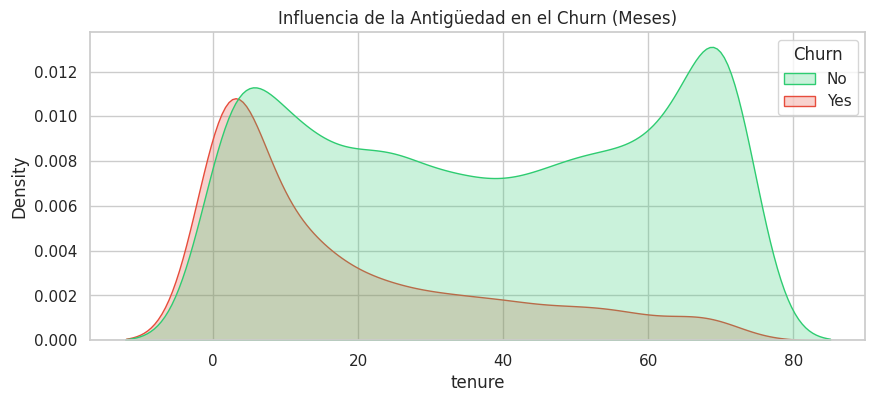

In [31]:
# Configuración estética
sns.set_style("whitegrid")
palette_churn = {"Yes": "#E74C3C", "No": "#2ECC71"}

# --- INSIGHT 1: La antigüedad del cliente (Tenure) frente al abandono
plt.figure(figsize=(10, 4))
sns.kdeplot(data=df, x='tenure', hue='Churn', fill=True, palette=palette_churn)
plt.title('Influencia de la Antigüedad en el Churn (Meses)')
plt.show()

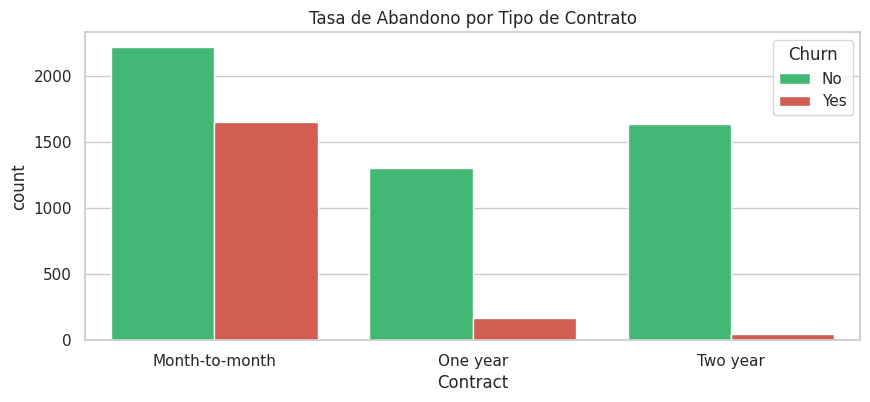

In [32]:
# --- INSIGHT 2: Contratos mes a mes ---
plt.figure(figsize=(10, 4))
contract_order = ['Month-to-month', 'One year', 'Two year']
sns.countplot(data=df, x='Contract', hue='Churn', order=contract_order, palette=palette_churn)
plt.title('Tasa de Abandono por Tipo de Contrato')
plt.show()

/tmp/ipykernel_70872/2577621463.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)


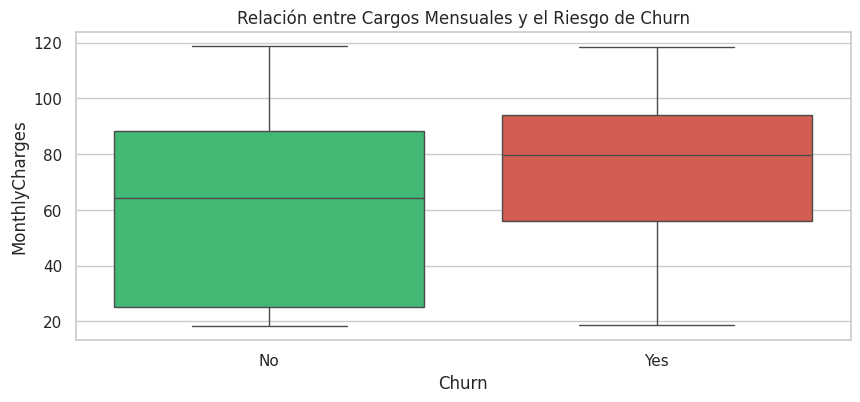

In [33]:
# --- INSIGHT 3: Cargos mensuales altos ---
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='Churn', y='MonthlyCharges', palette=palette_churn)
plt.title('Relación entre Cargos Mensuales y el Riesgo de Churn')
plt.show()

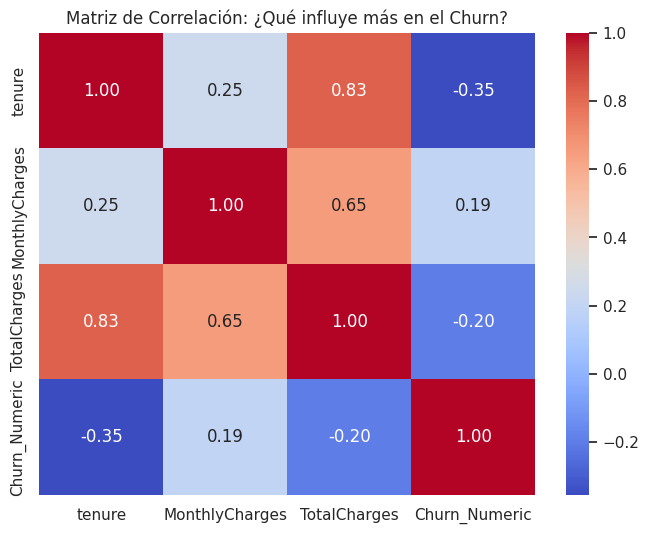

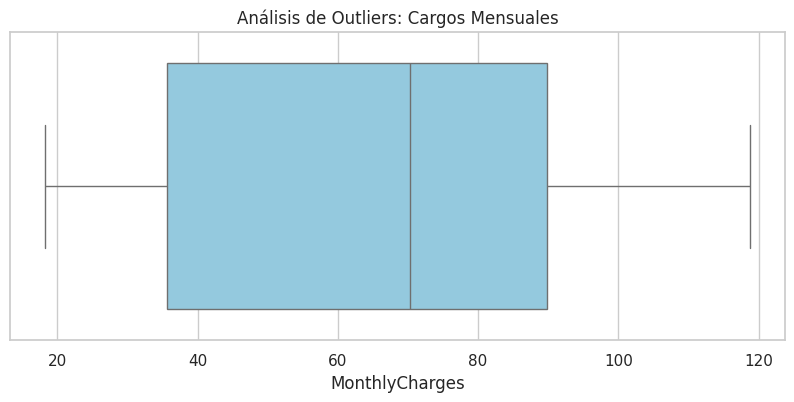

In [34]:
# 1. Preparación para correlación: Convertir Churn a binario (0 y 1)
df_corr = df.copy()
df_corr['Churn_Numeric'] = df_corr['Churn'].map({'Yes': 1, 'No': 0})

# 2. Matriz de Correlación (Solo variables clave)
plt.figure(figsize=(8, 6))
cols_interes = ['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_Numeric']
sns.heatmap(df_corr[cols_interes].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación: ¿Qué influye más en el Churn?')
plt.show()

# 3. Detección de Outliers en Cargos Mensuales
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['MonthlyCharges'], color='skyblue')
plt.title('Análisis de Outliers: Cargos Mensuales')
plt.show()

### Modelado

### Regresión Logistica

### Ridge

### Lasso

### Elasticnet

### SGDClassifier

### LDA

### SVM

### KNN

### Naïve Bayes

### Árboles de Decisión

###  MLPClassifier

### Random Forest

### Gradient Boosting

### AdaBoost